# Plagiarism Detection Model (Local optimization version)

**Note to reviewer:** I have access to workstation with a beefy GPU (Geforce Ti 2080 RTX) so I prefer testing everything locally before spending some time (and money) on a Sagemaker notebook instance.

This noteboook contains all the code used to create and test the two models locally before moving them to the appropriate files. Its only goal is to speed up my completion of the project.


In [1]:
# Imports
import os
import sys
import subprocess
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from joblib import load
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 125
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sys.path.append("source_pytorch/")


In [2]:
# Dummy environment variables to mimic AWS environment
AWS_env = {
    'SM_HOSTS': "{}",
    'SM_CURRENT_HOST': "localhost",
    'SM_MODEL_DIR': "model",
    'SM_CHANNEL_TRAIN': "plagiarism_data",
    'SM_OUTPUT_DATA_DIR': "",
    'SM_NUM_GPUS': "1"
}


# Useful function to run external script
def run_script(script_path, script_args={}):
    python_exe = sys.executable

    args = [
        python_exe,
        script_path,
    ]

    for key, val in script_args.items():
        args.extend(["--{}".format(key), str(val)])

    env = AWS_env.copy()  # Copy in case we modify it

    print("Running the following command:\n{}".format(
        " ".join(args)))

    output = subprocess.run(
       args,
       env=env,
       capture_output=True,
       text=True
       )

    if output.returncode != 0:
        raise RuntimeError(
            "Script failed!\nOutput:\n{}".format(output.stderr))
    else:
        print("Script gracefully ended.\nOutput:\n{}".format(output.stdout))

def print_model_validation(model):
    all_x = np.concatenate((train_x, test_x))
    all_y = np.concatenate((train_y, test_y))
    try:
        test_predictions = model.predict(test_x.values)
        train_predictions = model.predict(train_x.values)
        all_predictions = model.predict(all_x)
    except AttributeError:
        # Pytorch model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        model = model.eval().to(device)
        test_data = torch.from_numpy(test_x.values.astype(np.float32)).to(device)
        train_data = torch.from_numpy(train_x.values.astype(np.float32)).to(device)
        all_data = torch.from_numpy(all_x.astype(np.float32)).to(device)
        
        test_predictions = np.round(model(test_data).tolist()).astype(int)
        train_predictions = np.round(model(train_data).tolist()).astype(int)
        all_predictions = np.round(model(all_data).tolist()).astype(int)
    
    score = accuracy_score(test_y.values, test_predictions) * 100
    print("Results for {}:".format(model.__class__.__name__))
    print("- Accuracies: {:.2f}% (test),  {:.2f}% (train), {:.2f}% (all) -> {}".format(
        score,
        accuracy_score(train_y, train_predictions) * 100,
        accuracy_score(all_y, all_predictions) * 100,
        "PASSED" if score > 90 else "FAILED"))
    print("- Confusion matrices:")
    
    confusion_matrics = {
        "Test data" : confusion_matrix(test_y, test_predictions),
        "Train data" : confusion_matrix(train_y, train_predictions),
        "All data" : confusion_matrix(all_y, all_predictions),
    }
    
    fig, axes = plt.subplots(ncols=3, figsize=(8,24))
    for i, (title, matrix) in enumerate(confusion_matrics.items()):
        ax = axes[i]
        ax.set_title(title)
        visu = ConfusionMatrixDisplay(matrix, ["Original", "Plagiarism"])
        visu.plot(cmap=plt.cm.Blues, ax=ax)
        ax.images[0].colorbar.remove()
        if i > 0:
            ax.get_yaxis().set_visible(False)
        
    plt.show()

In [3]:
# Load data

train_data = pd.read_csv("plagiarism_data/train.csv", header=None, names=None)

# Labels are in the first column
train_y = train_data.iloc[:,0]
train_x = train_data.iloc[:,1:]

test_data = pd.read_csv("plagiarism_data/test.csv", header=None, names=None)

# Labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

## Creating and testing the Naive Bayes classifier

Results for GaussianNB:
- Accuracies: 100.00% (test),  94.29% (train), 95.79% (all) -> PASSED
- Confusion matrices:


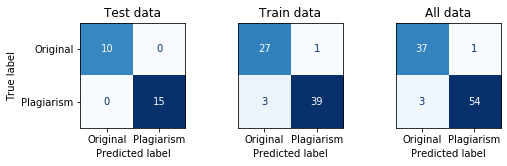

CPU times: user 259 ms, sys: 2.59 ms, total: 261 ms
Wall time: 259 ms


In [4]:
%%time

clf = GaussianNB() # Base estimator
clf.fit(train_x, train_y)

print_model_validation(clf)


## Creating and testing the PyTorch model

In [5]:
!pygmentize source_pytorch/model.py


# torch imports
import torch.nn.functional as F
import torch.nn as nn


## TODO: Complete this classifier
class BinaryClassifier(nn.Module):
    """
    Define a neural network that performs binary classification.
    The network should accept your number of features as input, and produce 
    a single sigmoid value, that can be rounded to a label: 0 or 1, as output.
    
    Notes on training:
    To train a binary classifier in PyTorch, use BCELoss.
    BCELoss is binary cross entropy loss, documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss
    """

    ## TODO: Define the init function, the input params are required (for loading code in train.py to work)
    def __init__(self, input_features, hidden_dim, output_dim):
        """
        Initialize the model by setting up linear layers.
        Use the input parameters to help define the layers of your model.
        :param input_features: the number of input features in your training/test data
        :param hid

In [6]:
import model
import train
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf = model.BinaryClassifier(2, 32, 8).to(device)

train_loader = train._get_train_data_loader(10, "plagiarism_data/")

optimizer = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.BCELoss()

losses = train.train(clf, train_loader, 50, criterion, optimizer, device)

Get train data loader.
Epoch: 1, Loss: 0.7812682645661491
Epoch: 2, Loss: 0.7421102353504726
Epoch: 3, Loss: 0.7183866671153477
Epoch: 4, Loss: 0.6980492898396083
Epoch: 5, Loss: 0.6783029011317662
Epoch: 6, Loss: 0.6425322719982692
Epoch: 7, Loss: 0.6230431028774807
Epoch: 8, Loss: 0.6073594433920724
Epoch: 9, Loss: 0.5849015116691589
Epoch: 10, Loss: 0.5662366492407662
Epoch: 11, Loss: 0.5392773790018899
Epoch: 12, Loss: 0.5237755094255719
Epoch: 13, Loss: 0.5173969651971545
Epoch: 14, Loss: 0.4689957797527313
Epoch: 15, Loss: 0.47298947828156607
Epoch: 16, Loss: 0.45714673825672697
Epoch: 17, Loss: 0.4211261400154659
Epoch: 18, Loss: 0.4217843881675175
Epoch: 19, Loss: 0.41190989528383526
Epoch: 20, Loss: 0.3829768214906965
Epoch: 21, Loss: 0.3685687780380249
Epoch: 22, Loss: 0.3692865882601057
Epoch: 23, Loss: 0.36117214390209745
Epoch: 24, Loss: 0.340019519839968
Epoch: 25, Loss: 0.34178797687803
Epoch: 26, Loss: 0.3186572662421635
Epoch: 27, Loss: 0.31538577377796173
Epoch: 28, L

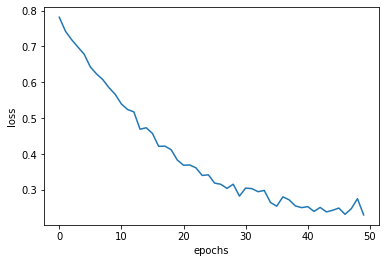

In [7]:
# Check if the number of epochs is OK
sns.lineplot(x=np.arange(len(losses)), y=losses, palette="muted")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Results for BinaryClassifier:
- Accuracies: 100.00% (test),  95.71% (train), 96.84% (all) -> PASSED
- Confusion matrices:


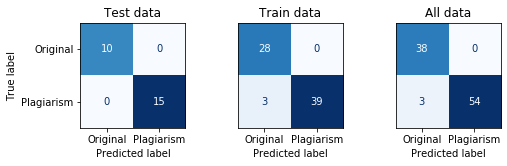

In [8]:
print_model_validation(clf)

## Test training script (Sklearn model)

In [9]:
# Run script
run_script("source_sklearn/train.py", {})

Running the following command:
/home/sbuchoux/miniconda3/envs/DataScience/bin/python source_sklearn/train.py
Script gracefully ended.
Output:
Model saved to model/model.joblib



Results for GaussianNB:
- Accuracies: 100.00% (test),  94.29% (train), 95.79% (all) -> PASSED
- Confusion matrices:


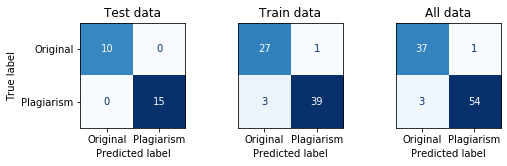

In [10]:
# Check that the saved model is OK
clf = load('model/model.joblib')
print_model_validation(clf)

## Test training script (Pytorch model)

In [11]:
# Run script
run_script("source_pytorch/train.py", {"epochs": 50, "seed":42})

Running the following command:
/home/sbuchoux/miniconda3/envs/DataScience/bin/python source_pytorch/train.py --epochs 50 --seed 42
Script gracefully ended.
Output:
Using device cuda.
Get train data loader.
Epoch: 1, Loss: 0.7812682645661491
Epoch: 2, Loss: 0.7421102353504726
Epoch: 3, Loss: 0.7183866671153477
Epoch: 4, Loss: 0.6980492898396083
Epoch: 5, Loss: 0.6783029011317662
Epoch: 6, Loss: 0.6425322719982692
Epoch: 7, Loss: 0.6230431028774807
Epoch: 8, Loss: 0.6073594433920724
Epoch: 9, Loss: 0.5849015116691589
Epoch: 10, Loss: 0.5662366492407662
Epoch: 11, Loss: 0.5392773790018899
Epoch: 12, Loss: 0.5237755094255719
Epoch: 13, Loss: 0.5173969651971545
Epoch: 14, Loss: 0.4689957797527313
Epoch: 15, Loss: 0.47298947828156607
Epoch: 16, Loss: 0.45714673825672697
Epoch: 17, Loss: 0.4211261400154659
Epoch: 18, Loss: 0.4217843881675175
Epoch: 19, Loss: 0.41190989528383526
Epoch: 20, Loss: 0.3829768214906965
Epoch: 21, Loss: 0.3685687780380249
Epoch: 22, Loss: 0.3692865882601057
Epoch: 2

Loading model.
model_info: {'input_features': 2, 'hidden_dim': 32, 'output_dim': 8}
Done loading model.
Results for BinaryClassifier:
- Accuracies: 100.00% (test),  95.71% (train), 96.84% (all) -> PASSED
- Confusion matrices:


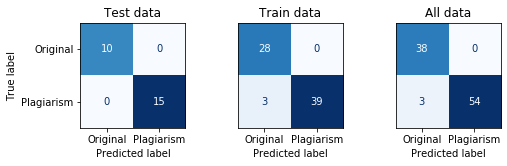

In [12]:
# Check that the saved model is OK
import predict

clf = predict.model_fn("model/")

print_model_validation(clf)

In [13]:
predictions = predict.predict_fn(test_x.values, clf)

print("{:.2f}%".format(accuracy_score(test_y, predictions)*100))
print(confusion_matrix(test_y, predictions))
confusion_matrix(test_y, predictions)[0,1]

Predicting class labels for the input data...
100.00%
[[10  0]
 [ 0 15]]


0